In [1]:
# import kagglehub

# # Download latest version
# path = kagglehub.dataset_download("aquibiqbal/mnistm")

# print("Path to dataset files:", path)

In [2]:
import torch
import torch.nn as nn
import torch.functional as F
import matplotlib.pyplot as plt
import torchvision
import torchvision.transforms as transforms
import numpy as np
import os
from PIL import Image
from torch.utils.data import Dataset
from tqdm import tqdm
from torch import optim

# Utils

In [3]:
def plot_loss(loss_all):
    plt.figure(figsize=(6,6))
    epochs_all = np.arange(1, len(loss_all)+1, 1)
    plt.plot(epochs_all, loss_all, marker="", label='loss')
    plt.title('Loss')
    plt.xlabel('epoch')
    plt.ylabel('Loss')
    # plt.show()
    plt.savefig('../loss.png', dpi=300, bbox_inches='tight')

# Model Utils

In [4]:
class DoubleConv(nn.Module):
    def __init__(self, in_channels, out_channels):
        super().__init__()
        self.double_conv = nn.Sequential(
            nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1, bias=False),
            nn.GroupNorm(1, out_channels), # (GroupNumbers, Channels)
            nn.GELU(),
            nn.Conv2d(out_channels, out_channels, kernel_size=3, padding=1, bias=False),
            nn.GroupNorm(1, out_channels),
        )

    def forward(self, x):
        output = self.double_conv(x)
        return output
    
class Down(nn.Module):
    def __init__(self, in_channels, out_channels, emb_dim=256): # emb_dim is hyperparameter
        super().__init__()

        self.maxpool_conv = nn.Sequential(
            nn.MaxPool2d(2),
            # DoubleConv(in_channels, in_channels, residual=True),
            DoubleConv(in_channels, out_channels),
        )

        # convert the dimension of emb_dim to out_channels
        self.emb_layer = nn.Sequential(
            nn.SiLU(),
            nn.Linear(
                emb_dim, 
                out_channels,
            ),
        )

    def forward(self, x, t):
        x = self.maxpool_conv(x)

        # get the time embedding
        emb = self.emb_layer(t)[:, :, None, None].repeat(1, 1, x.shape[-2], x.shape[-1]) # shape[-2] counts the array from back (batch_size, out_channels, H, W)

        # add the time embedding to the original image to tell the model how strong the noise is
        return x + emb
    
class Up(nn.Module):
    def __init__(self, in_channels, out_channels, emb_dim=256): # emb_dim is hyperparamter
        super().__init__()

        # scale_factor=2, 16x16 -> 32x32 which double the height and width
        # mode="bilinear", the new pixel is calculated as a weighted average of the 4 nearest original pixels
        # When align_corner set to True, it treats the corner pixels of the input and output as perfectly aligned
        self.up = nn.Upsample(scale_factor=2, mode="bilinear", align_corners=True)
        self.conv = nn.Sequential(
            DoubleConv(in_channels, out_channels),
        )

        self.emb_layer = nn.Sequential(
            nn.SiLU(),
            nn.Linear(
                emb_dim,
                out_channels
            ),
        )

    def forward(self, x, skip_x, t):
        x = self.up(x)
        x = torch.cat([skip_x, x], dim=1) # skip connection, skip_x is from encoder. dim = 1 represent the skip_x concat x with dimension 1 channels. [batch_size, channels, H, W]
        x = self.conv(x)
        emb = self.emb_layer(t)[:, :, None, None].repeat(1, 1, x.shape[-2], x.shape[-1])
        return x + emb
    
class SelfAttention(nn.Module):
    def __init__(self, channels, size):
        super().__init__()
        self.channels = channels
        self.size = size

        # num_heads=4 means there is 4 specialists
        # batch_first=True tells the program that the input is (batch, sequence, features)
        self.mha = nn.MultiheadAttention(channels, 4, batch_first=True)
        self.ln = nn.LayerNorm([channels])
        self.ff_self = nn.Sequential(
            nn.LayerNorm([channels]),
            nn.Linear(channels, channels),
            nn.GELU(),
            nn.Linear(channels, channels),
        )

    def forward(self, x):
        x = x.reshape(-1, self.channels, self.size * self.size).swapaxes(1, 2) # Reshape x from (batch, channels, H, W) to (batch, H*W, channels)
        x_ln = self.ln(x)
        attention_value, _ = self.mha(x_ln, x_ln, x_ln) # Three input: Query, Key and Value. To find internal relationship
        attention_value = attention_value + x # residual connection
        attention_value = self.ff_self(attention_value) + attention_value # Feed-Forward Network and another residual connection
        return attention_value.swapaxes(2, 1).reshape(-1, self.channels, self.size, self.size) # Reshape to (batch, channels, H, W)

# Model Body (UNet)


| Layer                | Input Size (Channels x H x W)         | Output Size (Channels x H x W)        | Notes                                                                  |
|----------------------|---------------------------------------|---------------------------------------|------------------------------------------------------------------------|
| `self.inc(x)`        | `c_in x H x W`                        | `32 x H x W`                          |
| `self.down1(x1)`     | `32 x H x W`                          | `64 x H/2 x W/2`                      |
| `self.sa1(x2)`       | `64 x H/2 x W/2`                      | `64 x H/2 x W/2`                      |
| `self.down2(x2)`     | `64 x H/2 x W/2`                      | `128 x H/4 x W/4`                     |
| `self.sa2(x3)`       | `128 x H/4 x W/4`                     | `128 x H/4 x W/4`                     |
| `self.down3(x3)`     | `128 x H/4 x W/4`                     | `128 x H/8 x W/8`                     |
| `self.sa3(x4)`       | `128 x H/8 x W/8`                     | `128 x H/8 x W/8`                     |
| `self.bot1(x4)`      | `128 x H/8 x W/8`                     | `256 x H/8 x W/8`                     |
| `self.bot2(x4)`      | `256 x H/8 x W/8`                     | `256 x H/8 x W/8`                     |
| `self.bot3(x4)`      | `256 x H/8 x W/8`                     | `128 x H/8 x W/8`                     |
| `self.up1(x4, x3)`   | `128 x H/8 x W/8` & `128 x H/4 x W/4` | `128 x H/4 x W/4`                     |
| `self.sa4(x)`        | `128 x H/4 x W/4`                     | `128 x H/4 x W/4`                     |
| `self.up2(x3, x2)`   | `128 x H/4 x W/4` & `64 x H/2 x W/2`  | `64 x H/2 x H/2`                      |
| `self.sa5(x)`        | `64 x H/2 x W/2`                      | `64 x H/2 x W/2`                      |
| `self.up3(x2, x1)`   | `64 x H/2 x W/2`  & `32 x H x W`      | `32 x H x W`                          |
| `self.sa6(x)`        | `32 x H x W`                          | `32 x H x W`                          |
| `self.outc(x)`       | `32 x H x W`                          | `c_out x H x W`                       |

In [5]:
class UNet(nn.Module):
    # num_classes tell the model how may different categories of images it should learn to generate
    def __init__(self, c_in=3, c_out=3, img_size=64, time_dim=256, device='cuda'):
        super().__init__()
        self.img_size = img_size
        self.time_dim = time_dim
        self.device = device

        self.inc = DoubleConv(in_channels=3, out_channels=64) # (3, 64, 64) -> (64, 64, 64)
        self.down1 = Down(in_channels=64, out_channels=128) # (64, 64, 64) -> (128, 32, 32)
        self.sa1 = SelfAttention(channels=128, size=int(img_size/2)) # (128, 32, 32) -> (128, 32, 32)
        self.down2 = Down(in_channels=128, out_channels=256) # (128, 32, 32) -> (256, 16, 16)
        self.sa2 = SelfAttention(channels=256, size=int(img_size/4)) # (256, 16, 16) -> (256, 16, 16)
        self.down3 = Down(in_channels=256, out_channels=256) # (256, 16, 16) -> (256, 8, 8)
        self.sa3 = SelfAttention(channels=256, size=int(img_size/8)) # (256, 8, 8) -> (256, 8, 8)

        self.bot1 = DoubleConv(in_channels=256, out_channels=512) # (256, 8, 8) -> (512, 8, 8)
        self.bot2 = DoubleConv(in_channels=512, out_channels=512) # (512, 8, 8) -> (512, 8, 8)
        self.bot3 = DoubleConv(in_channels=512, out_channels=256) # (512, 8, 8) -> (256, 8, 8)

        self.up1 = Up(in_channels=512, out_channels=128) # (256, 8, 8) -> (256, 16, 16)
        self.sa4 = SelfAttention(channels=128, size=int(img_size/4)) # (128, 16, 16) -> (128, 16, 16)
        self.up2 = Up(in_channels=256, out_channels=64) # (256, 16, 16) -> (128, 32, 32)
        self.sa5 = SelfAttention(channels=64, size=int(img_size/2)) # (64, 32, 32) -> (64, 32, 32)
        self.up3 = Up(in_channels=128, out_channels=64) # (128, 32, 32) -> (64, 64, 64)
        self.sa6 = SelfAttention(channels=64, size=img_size) # (64, 64, 64) -> (64, 64, 64)
        self.outc = nn.Conv2d(in_channels=64, out_channels=c_out, kernel_size=1) # (64, 64, 64) -> (3, 64, 64)

    def pos_encoding(self, t, channels):
        # sinusoidal embedding formula
        inv_freq = 1.0 / (10000 ** (torch.arange(0, channels, 2).float() / channels)).to(self.device) # 1.0 / (10000 ** [0/128, 2/128, ..., 126/128])
        pos_enc_a = torch.sin(t.repeat(1, channels // 2) * inv_freq) # even dimension
        pos_enc_b = torch.cos(t.repeat(1, channels // 2) * inv_freq) # odd dimension
        pos_enc = torch.cat([pos_enc_a, pos_enc_b], dim=-1)
        return pos_enc

    def forward(self, x, t):
        t = t.unsqueeze(-1).to(torch.float) # [t] -> [t,]
        t = self.pos_encoding(t, self.time_dim)

        x1 = self.inc(x)
        x2 = self.down1(x1, t)
        x2 = self.sa1(x2)
        x3 = self.down2(x2, t)
        x3 = self.sa2(x3)
        x4 = self.down3(x3, t)
        x4 = self.sa3(x4)

        x4 = self.bot1(x4)
        x4 = self.bot2(x4)
        x4 = self.bot3(x4)

        x = self.up1(x4, x3, t)
        x = self.sa4(x)
        x = self.up2(x, x2, t)
        x = self.sa5(x)
        x = self.up3(x, x1, t)
        x = self.sa6(x)
        output = self.outc(x)

        return output

# Diffusion Model

In [6]:
class Diffusion:
    def __init__(self, steps=1000, beta_start=1e-4, beta_end=2e-2, img_size=32, device='cuda'):
        self.steps = steps
        self.beta_start = beta_start
        self.beta_end = beta_end
        self.img_size = img_size
        self.device = device
        
        self.beta = self.linear_schedular().to(device)
        self.alpha = 1 - self.beta
        self.alpha_bar = torch.cumprod(self.alpha, dim=0)

    # the hyperparamter which decides the parameter to noise images
    def linear_schedular(self):
        return torch.linspace(self.beta_start, self.beta_end, self.steps) # to get beta

    def noise_images(self, x, t):
        sqrt_alpha_bar = torch.sqrt(self.alpha_bar[t])[:, None, None, None] # [batch_size, 1, 1, 1]. The batch_size is from datasets
        sqrt_one_minus_alpha_bar = torch.sqrt(1 - self.alpha_bar[t])[:, None, None, None] # [batch_size, 1, 1, 1]
        z = torch.randn_like(x) # find a random number from a standard normal distribution. The format of the z is like x. x:[batch, channels, height, width]
        return sqrt_alpha_bar * x + sqrt_one_minus_alpha_bar * z, z # z is the noise we add to image. We need it to calculate loss
    
    def sample_timesteps(self, n):
        return torch.randint(low=1, high=self.steps, size=(n,)) # return the random timesteps for training
    
    def sample(self, model, n, image_channels):
        result = []
        model.eval()
        with torch.no_grad():
            x = torch.randn((n, image_channels, self.img_size, self.img_size)).to(self.device) # get a random tensor from standard normal distribution numbers
            for i in tqdm(reversed(range(1, self.steps)), position=0):  # Fixed: was self.noise_images, should be self.steps
                t = (torch.ones(n) * i).long().to(self.device)  # Fixed: specify batch size n
                predicted_noise = model(x, t)
                alpha = self.alpha[t][:, None, None, None]
                alpha_bar = self.alpha_bar[t][:, None, None, None]
                beta = self.beta[t][:, None, None, None]
                if i > 1:
                    noise = torch.randn_like(x)
                else:
                    noise = torch.zeros_like(x)
                x = 1 / torch.sqrt(alpha) * (x - ((1 - alpha) / (torch.sqrt(1 - alpha_bar))) * predicted_noise) + torch.sqrt(beta) * noise
                if (i % 100 == 0):
                    result.append(x)
        model.train()
        result.append(x)
        result = torch.cat(result)
        result = (result.clamp(-1,1) + 1) / 2 # denormalize the value. Clip the pixel value to [-1,1]. (+1) Shift the value to [0,2]. (/2) Scales the range down to [0,1]
        result = (result * 255).type(torch.uint8) # converts the pixel value to a standard 8-bit image format 
        return result

# Train

Found 60000 images in the dataset


100%|██████████| 7500/7500 [08:16<00:00, 15.09it/s, MSE=0.00704] 


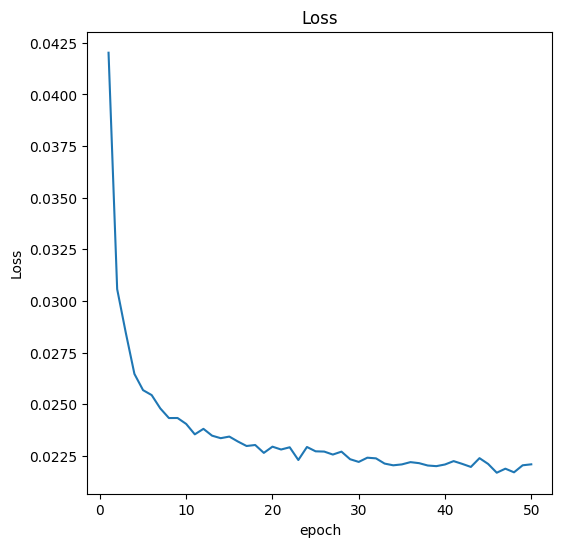

In [7]:
class MNISTMDataset(Dataset):
    def __init__(self, data_dir, transform=None):
        self.data_dir = data_dir
        self.transform = transform
        # Get all .jpg files in the directory
        self.image_files = [f for f in os.listdir(data_dir) if f.endswith('.jpg')]
        self.image_files.sort()  # Sort to ensure consistent ordering
        
    def __len__(self):
        return len(self.image_files)
    
    def __getitem__(self, idx):
        img_path = os.path.join(self.data_dir, self.image_files[idx])
        image = Image.open(img_path).convert('RGB')
        
        if self.transform:
            image = self.transform(image)
            
        # Return image and dummy label (0) since we don't need labels for DDPM
        return image, 0

def data_preprocessing():
    IMG_SIZE = 32
    BATCH_SIZE = 8

    transforms_pipeline = transforms.Compose([
        transforms.Resize((IMG_SIZE, IMG_SIZE)),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.5,0.5,0.5], std=[0.5,0.5,0.5]), # normalize to [-1,1]
    ])

    data_folder_path = './1/mnistm'
    data = MNISTMDataset(data_dir=data_folder_path, transform=transforms_pipeline)
    print(f'Found {len(data)} images in the dataset')

    dataloader = torch.utils.data.DataLoader(
        data,
        batch_size=BATCH_SIZE,
        shuffle=True,
        num_workers=2,
    )

    return dataloader

def train(epochs=20, model_path=None, dataloader=None, model=None, diffusion=None):
    device = 'cuda' if torch.cuda.is_available() else 'cpu'
    model.to(device)

    optimizer = optim.Adam(model.parameters(), lr=0.001)
    mse = nn.MSELoss()

    l = len(dataloader)
    loss_all = []

    for epoch in range(epochs):
        pbar = tqdm(dataloader)
        epoch_loss = 0.0
        for i, (images, _) in enumerate(pbar):
            images = images.to(device)
            t = diffusion.sample_timesteps(images.shape[0]).to(device)
            x_t, noise = diffusion.noise_images(images, t)
            predicted_noise = model(x_t, t)
            loss = mse(noise, predicted_noise)

            optimizer.zero_grad() # reset the gradients
            loss.backward() # calculate the gradients
            optimizer.step() # update all the models parameter
            epoch_loss += loss.item() # calculate the epoch loss
            pbar.set_postfix(MSE=loss.item()) # display the loss of each batch
    
        avg_loss = epoch_loss / l
        loss_all.append(avg_loss)

    return loss_all

device = 'cuda' if torch.cuda.is_available() else 'cpu'
model = UNet(c_in=3, c_out=3, img_size=32, time_dim=256, device=device) 
diffusion = Diffusion(steps=1000, beta_start=1e-4, beta_end=2e-2, img_size=32, device=device)
dataloader = data_preprocessing()
loss_all = train(epochs=50, dataloader=dataloader, model=model, diffusion=diffusion)

plot_loss(loss_all)

# Sample

In [21]:
# Plot and save the generated images
def plot_sample_images(sample_images, save_path='generated_samples.png', title_prefix='Sample'):
    """
    Plot and save the generated sample images
    Args:
        sample_images: tensor of shape (n_samples, channels, height, width)
        save_path: path to save the plotted image
        title_prefix: prefix for the title of each sample
    """
    # Add visual separation between different sample sets
    print("\n" + "="*60)
    print(f"Generating plot: {save_path}")
    print("="*60)
    
    # Convert tensor to numpy and rearrange dimensions for plotting
    if sample_images.is_cuda:
        sample_images = sample_images.cpu()
    
    # Get the number of images
    n_images = sample_images.shape[0]
    
    # Determine grid layout for better readability
    if n_images == 1:
        nrows, ncols = 1, 1
        figsize = (6, 6)
    elif n_images == 2:
        nrows, ncols = 1, 2
        figsize = (12, 6)
    elif n_images <= 4:
        nrows, ncols = 2, 2
        figsize = (12, 12)
    elif n_images <= 6:
        nrows, ncols = 2, 3
        figsize = (15, 10)
    elif n_images <= 9:
        nrows, ncols = 3, 3
        figsize = (15, 15)
    else:
        # For more than 9 images, arrange in rows of 4
        ncols = 4
        nrows = (n_images + ncols - 1) // ncols
        figsize = (16, 4 * nrows)
    
    # Create subplot grid
    fig, axes = plt.subplots(nrows, ncols, figsize=figsize)
    
    # Handle single subplot case
    if n_images == 1:
        axes = [axes]
    elif nrows == 1 or ncols == 1:
        # For single row or column, ensure axes is always a list
        if not isinstance(axes, np.ndarray):
            axes = [axes]
        elif axes.ndim == 1:
            axes = axes.flatten()
    else:
        # For 2D grid, flatten to 1D list
        axes = axes.flatten()
    
    for i in range(n_images):
        # Convert from (C, H, W) to (H, W, C) for matplotlib
        img = sample_images[i].permute(1, 2, 0).numpy()
        
        # Plot the image
        axes[i].imshow(img)
        axes[i].axis('off')
        axes[i].set_title(f'{title_prefix} {i+1}', fontsize=14, fontweight='bold')
    
    # Hide unused subplots
    for i in range(n_images, len(axes)):
        axes[i].axis('off')
    
    plt.tight_layout()
    plt.savefig(save_path, dpi=300, bbox_inches='tight')
    plt.show()
    print(f"Images saved to {save_path}")
    print("="*60 + "\n")

# Alternative: Save individual images
def save_individual_images(sample_images, folder_path='generated_images'):
    """
    Save each generated image as a separate file
    Args:
        sample_images: tensor of shape (n_samples, channels, height, width)
        folder_path: folder to save individual images
    """
    import os
    
    # Add visual separation
    print("\n" + "-"*40)
    print(f"Saving individual images to: {folder_path}")
    print("-"*40)
    
    # Create folder if it doesn't exist
    os.makedirs(folder_path, exist_ok=True)
    
    if sample_images.is_cuda:
        sample_images = sample_images.cpu()
    
    for i in range(sample_images.shape[0]):
        # Convert tensor to PIL Image
        img_tensor = sample_images[i]
        
        # Convert from tensor to PIL Image
        img_pil = transforms.ToPILImage()(img_tensor)
        
        # Save the image
        img_path = os.path.join(folder_path, f'sample_{i+1}.png')
        img_pil.save(img_path)
        print(f"Saved image {i+1} to {img_path}")
    
    print("-"*40 + "\n")

# Option 3: Create a grid of images using torchvision
def create_image_grid(sample_images, save_path='image_grid.png', nrow=2, title='Generated DDPM Samples'):
    """
    Create a grid of images using torchvision.utils.make_grid
    Args:
        sample_images: tensor of shape (n_samples, channels, height, width)
        save_path: path to save the grid image
        nrow: number of images per row in the grid
        title: title for the grid plot
    """
    # Add visual separation
    print("\n" + "~"*50)
    print(f"Creating image grid: {save_path}")
    print("~"*50)
    
    # Create grid
    grid = torchvision.utils.make_grid(sample_images, nrow=nrow, padding=2, normalize=False)
    
    # Convert to PIL and save
    grid_pil = transforms.ToPILImage()(grid.cpu())
    grid_pil.save(save_path)
    
    # Also display using matplotlib with larger figure
    plt.figure(figsize=(12, 12))
    plt.imshow(grid.permute(1, 2, 0).cpu().numpy())
    plt.axis('off')
    plt.title(title, fontsize=16, fontweight='bold', pad=20)
    plt.tight_layout()
    plt.show()
    print(f"Grid saved to {save_path}")
    print("~"*50 + "\n")

999it [00:14, 69.40it/s]


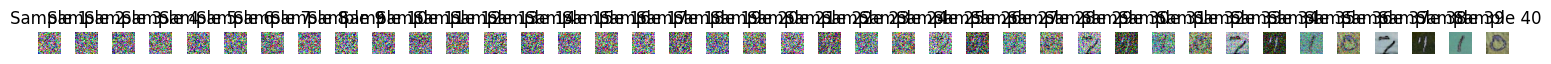

Images saved to generated_ddpm_samples.png


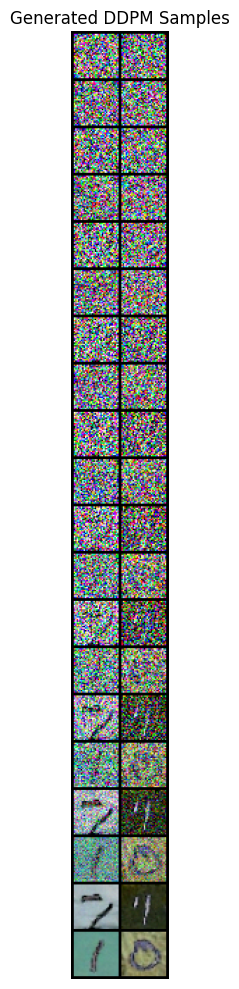

Grid saved to ddpm_grid.png


In [ ]:
sample_images = diffusion.sample(model=model, n=4, image_channels=3)
# Plot the generated images with clear separation
plot_sample_images(sample_images, 'generated_ddpm_samples.png', title_prefix='Original Training')

# Create and display image grid
create_image_grid(sample_images, 'ddpm_grid.png', nrow=2, title='Original Training - Generated DDPM Samples')

# Save Trained Model

In [22]:
def save_model(model, model_path='ddpm_model.pth'):
    """
    Save the trained model state dict
    """
    torch.save(model.state_dict(), model_path)
    print(f"Model saved to {model_path}")

def load_model(model_path='ddpm_model.pth', device='cuda'):
    """
    Load a saved model
    """
    device = device if torch.cuda.is_available() else 'cpu'
    model = UNet(c_in=3, c_out=3, img_size=32, time_dim=256, device=device)
    model.load_state_dict(torch.load(model_path, map_location=device))
    model.to(device)
    model.eval()
    print(f"Model loaded from {model_path}")
    return model

# Save the current trained model
save_model(model, 'ddpm_model.pth')

# You can also save with a specific name/path
# save_model(model, './models/ddpm_model_trained.pth')

print(f"Your trained model has been saved!")
print(f"To load it later, use: model = load_model('ddmp_model.pth')")

Model saved to ddpm_model.pth
Your trained model has been saved!
To load it later, use: model = load_model('ddmp_model.pth')


# Load Saved Model (for future use)

Model loaded from ddpm_model.pth


999it [00:14, 69.72it/s]




Generating plot: loaded_model_final_samples.png


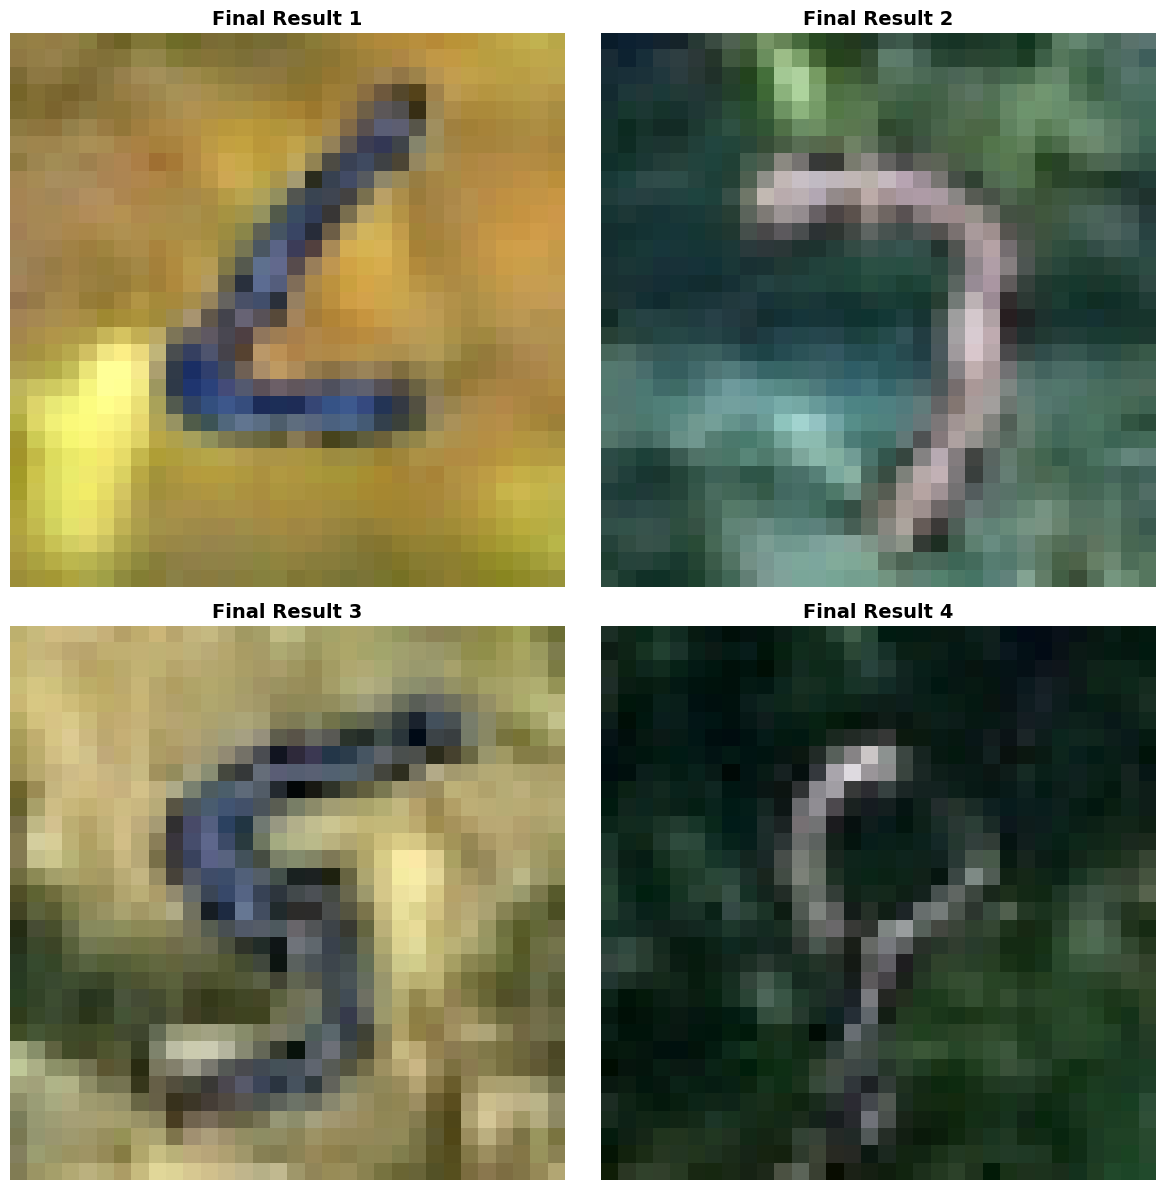

Images saved to loaded_model_final_samples.png

Total images generated during sampling: 40
The plot above shows only the final 4 clean results.
If you want to see the full denoising progression, uncomment the line below:

🎉 SUCCESS! 🎉
Your saved model works perfectly!
You can now generate new samples anytime without retraining!


In [24]:
# Load the saved model and test it
device = 'cuda' if torch.cuda.is_available() else 'cpu'
model = load_model('ddpm_model.pth', device=device)
diffusion = Diffusion(steps=1000, beta_start=1e-4, beta_end=2e-2, img_size=32, device=device)

# Generate samples with the loaded model
sample_images = diffusion.sample(model=model, n=4, image_channels=3)

# Show only the final 4 clean images (last 4 from the tensor)
final_images = sample_images[-4:]  # Get the last 4 images (final results)
plot_sample_images(final_images, 'loaded_model_final_samples.png', title_prefix='Final Result')

# Optional: Show the progression (all intermediate steps)
print(f"Total images generated during sampling: {sample_images.shape[0]}")
print("The plot above shows only the final 4 clean results.")
print("If you want to see the full denoising progression, uncomment the line below:")
# plot_sample_images(sample_images, 'loaded_model_all_steps.png', title_prefix='Step')

print("\n" + "🎉 SUCCESS! 🎉")
print("Your saved model works perfectly!")
print("You can now generate new samples anytime without retraining!")